<!--NAVIGATION-->
< [Introduction to Building Data Analytics](01.00-Introduction-to-Building-Data-Analytics.ipynb) | [Contents](Index.ipynb) | [Making a Sensitivity Analysis](01.02-Sensitivity-Analysis.ipynb) >

# Design Spaces

At the very basic level, design spaces can be thought of as the possible values parameters of an experiment can take. In our case, the experiment consists of an energy model for which we modify certain parameters (WWR, ROOFR, etc.) and evaluate certain results (EUI, TEDI, CEDI, etc.). The Design Space simply describes which parameters are studied, what their possible values are (ranges or sets of values).

A Design Space should not be confused with the process of sampling a design space, which is the action of getting a list of designs out of the design space. We cover the sampling of design space later in [Sampling the Design Space](#Sampling-the-Design-Space).

# Creating a Design Space

A design space is composed of **dimensions** that correspond to parameter values that define an energy model. Those dimensions can be specified as *Real*, *Integer* or *Categorical* values. Real and Integers specify a range (low, high) of possible values. Sampling methods will return designs with values falling within this range. Categorical dimensions, on the other hand, specifiy a fixed set of values.

We will start our code with the import of the `Space` class as well as the 3 possible dimension classes: `Real`, `Integer` and `Categorical`.

In [1]:
import os
from surrogate_schema import APIClient

%load_ext dotenv
%dotenv

# typical block to authenticate to the API
client = APIClient(api_url="https://api.elementa.nyc")
client.whoami()  # shows that you are properly authenticated

User(username='s.letellierduchesne', email='sam@cabonsignal.com', full_name='Samuel Letellier-Duchesne', disabled=None, valid_until=datetime.datetime(2025, 1, 29, 15, 28, 26))

In [2]:
from surrogate_schema import Space
from surrogate_schema.space.design_space import Dimension

A Space can be created from a list of categoricals, a list of reals and/or a list if integers as follows:

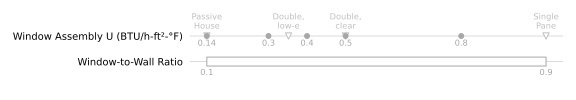

In [3]:
space = Space(
    dimensions=[
        Dimension(name="WINU", categories=[0.14, 0.3, 0.4, 0.5, 0.8]),
        Dimension(name="WWR", low=0.1, high=0.9),
    ],
)
space

As we see in the output, the units of a dimension are pre-defined and are consistant with the whole API workflow. You can also specify a design space using your own set of units and be confident that the following steps of the analysis will receive the dimensions in the correct units.

Moreover the Space is vizualized as a figure.

To supply custom units, a Dimension has a `units` attribute which defines the units of the input values. The input values will be converted to the `base_units` of the dimension:

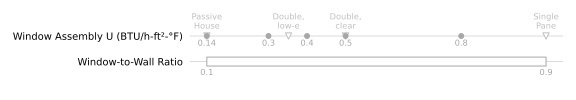

In [4]:
space = Space(
    dimensions=[
        Dimension(name="WINU", categories=[0.14, 0.3, 0.4, 0.5, 0.8]),
        Dimension(name="WWR", low=0.1, high=0.9),
    ],
)
space

For a list of predefined units commonly used in EnergyPlus, the `SiUnits` and `IpUnits` classes can be of help. They are imported like this:

In [5]:
from surrogate_schema.system_units import SiUnits, IpUnits

For example, the units of `heat_transfer_coefficient` in SI are:

In [6]:
SiUnits.heat_transfer_coefficient

<SiUnits.heat_transfer_coefficient: 'W/(m**2*degK)'>

And their conterpart in IP units are:

In [7]:
IpUnits.heat_transfer_coefficient

<IpUnits.heat_transfer_coefficient: 'Btu/(hr*ft**2*delta_degF)'>

Since `IpUnits` and `SiUnits` are [Enum](https://docs.python.org/3.8/library/enum.html)s of class `string`, one can very well pass an SiUnits (or an IpUnits) object directly to the units attribute of the Dimension:

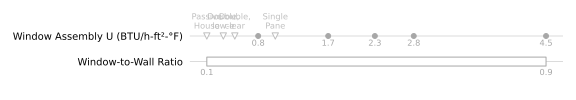

In [8]:
space = Space(
    dimensions=[
        Dimension(
            name="WINU",
            categories=(0.8, 1.7, 2.3, 2.8, 4.5),
            units=SiUnits.heat_transfer_coefficient,
        ),
        Dimension(name="WWR", low=0.1, high=0.9),
    ],
)
space

# Serializing Design Spaces

So far, the `space` object we created above lives in the computer's memory. For reproducibility and transferability, it can be practical to save the object as a file. It happens that the Space class - and all of the classes used in the SDK for that matter - is a data structure that is easily serializable, the process of converting an object into a JSON format.

The Space class inherits a `dict` method, and a `json` method. The dict method returns a dictionary representation of the Space object while the json method returns a string representation of the the dict representation!

In [9]:
space.dict()

{'dimensions': [{'name': 'WINU',
   'categories': [0.8, 1.7, 2.3, 2.8, 4.5],
   'low': None,
   'high': None,
   'baseline': None,
   'base': 10,
   'transformer': None,
   'prior': None,
   'dtype': 'float64',
   'practical_ranges': {'Passive House': 0.14,
    'Single Pane': 1.02,
    'Double, clear': 0.5,
    'Double, low-e': 0.352}},
  {'name': 'WWR',
   'categories': None,
   'low': 0.1,
   'high': 0.9,
   'baseline': None,
   'base': 10,
   'transformer': None,
   'prior': <Prior.uniform: 'uniform'>,
   'dtype': 'float64',
   'practical_ranges': None}],
 'reals': [],
 'integers': [],
 'categoricals': [],
 'space_id': UUID('ad125cd4-211e-4c94-b250-b58378e5924d'),
 'baseline': None,
 'version': '0.0.0'}

Above, the space object is returned as a `dict` while here the space is returned as a JSON string:

In [10]:
space.json()

'{"dimensions":[{"name":"WINU","categories":[0.8,1.7,2.3,2.8,4.5],"low":null,"high":null,"baseline":null,"base":10,"transformer":null,"prior":null,"dtype":"float64","practical_ranges":{"Passive House":0.14,"Single Pane":1.02,"Double, clear":0.5,"Double, low-e":0.352}},{"name":"WWR","categories":null,"low":0.1,"high":0.9,"baseline":null,"base":10,"transformer":null,"prior":"uniform","dtype":"float64","practical_ranges":null}],"reals":[],"integers":[],"categoricals":[],"space_id":"ad125cd4-211e-4c94-b250-b58378e5924d","baseline":null,"version":"0.0.0"}'

This JSON string is what we write to a file using a commonly used python `open` statement:

In [11]:
with open("data/my_design_space.json", "w") as file:
    file.write(space.model_dump_json(indent=3))  # indent with 3 spaces

Our space has been serialized to a file called `my_design_space.json` in the current directory from which this jupyter notebook server has been started. 

Later on, or in a different script, that particular design space can be recreated using the `parse_file` method:

In [12]:
space_copy = Space.parse_file("data/my_design_space.json")

We can see here that the two objects are actually equivalent since the data structure is the same.

In [13]:
space == space_copy

True

Note that in terms of memory objects, `space` and `space_copy` are not the same:

In [14]:
space is space_copy

False

# Saving the Design Space to the API

The API uses a database that can store objects used in an analysis. For instance, the space class can be saved to the database and retreived later on.

Any Space object has a unique id `space_id`

In [15]:
space.space_id

UUID('ad125cd4-211e-4c94-b250-b58378e5924d')

Simply call the `save` method and the unique id of the object will be used to identify the new entry in the database

In [16]:
space.save()

Similarly, a design space is retrieved from the database using the class constructor `Space.get()`:

In [17]:
space_copy = Space.get("aa31e7b5-d077-4ee0-986a-da84c7a1f9aa")

Note that this UUID may be different in your case!

Again, `space` and `space_copy` are equal but they are not the same object:

In [18]:
space == space_copy

False

# Sampling the Design Space

The process of sampling design spaces returns different designs with combinations of parameters. There are many ways of sampling design spaces:

- Random sampling: Randomly select values in each dimension
- Grid sampling: Generate samples from a regular grid.
- Latin-Hypercube (LHS) sampling: Generates samples such that each value appears only once in each row and column (For a two-dimension space). A space with more than 3 dimension is called a *hypercube*!
- And more...

Let's look at these 3 sampling methods.

## Random Sampling

With random sampling, each design is made up of a random value taken from each dimension. For example, given 25 samples (taking a multiple of 5 here will make plotting the subsequent sampling methods easier), we can randomly generate 25 designs from our design space:

In [19]:
X = space.sample(25, "random")
X

SampledSpace(space=Space(dimensions=[Dimension(name='WINU', categories=[0.8, 1.7, 2.3, 2.8, 4.5], low=None, high=None, baseline=None, base=10, transformer=None, prior=None, dtype=dtype('float64'), practical_ranges={'Passive House': 0.14, 'Single Pane': 1.02, 'Double, clear': 0.5, 'Double, low-e': 0.352}), Dimension(name='WWR', categories=None, low=0.1, high=0.9, baseline=None, base=10, transformer=None, prior=<Prior.uniform: 'uniform'>, dtype=dtype('float64'), practical_ranges=None)], space_id=UUID('ad125cd4-211e-4c94-b250-b58378e5924d'), baseline=None, version='0.0.0'), X=[[0.8, 0.621102514581262], [2.8, 0.4177620621809234], [2.3, 0.7309841143525965], [2.8, 0.35346889773509704], [2.8, 0.5544789221008555], [1.7, 0.7953019116489808], [1.7, 0.4489387391165436], [4.5, 0.7417181136641274], [4.5, 0.2150134596116517], [4.5, 0.6634087768946684], [1.7, 0.6636650465516581], [2.3, 0.2750336845392709], [2.8, 0.8398941028924521], [2.8, 0.4537126043233414], [1.7, 0.8274527671779781], [2.3, 0.147847

The output is a `SampledSpace` object which has 3 attribue:

1. `space`: The design space used to create the sampled space.
2. `sampler`: The sampler used.
3. `X`: The list of designs, in the form of a list of lists (or an array)

A convenient method transforms the SampledSpace object to a pandas DataFrame, which unlocks many useful data analytics techniques such as indexing, duplicates removal, plotting, etc.

In [20]:
X.to_df()

,WINU,WWR
0,0.8,0.621103
1,2.8,0.417762
2,2.3,0.730984
3,2.8,0.353469
4,2.8,0.554479
5,1.7,0.795302
6,1.7,0.448939
7,4.5,0.741718
8,4.5,0.215013
9,4.5,0.663409


The output shows that the sampling created 20 designs (from 0 to 19) for the 2 dimensions defined in the design space. The dimensions are shown as columns. For reference, to get the dimension names of a space:

In [21]:
space.dimension_names

['WINU', 'WWR']

It is also possible to get a single dimension by name:

In [22]:
space["WWR"]

Dimension(name='WWR', categories=None, low=0.1, high=0.9, baseline=None, base=10, transformer=None, prior=<Prior.uniform: 'uniform'>, dtype=dtype('float64'), practical_ranges=None)

or by position (index or the list returned by `space.dimension_names`):

In [23]:
space[0]

Dimension(name='WINU', categories=[0.8, 1.7, 2.3, 2.8, 4.5], low=None, high=None, baseline=None, base=10, transformer=None, prior=None, dtype=dtype('float64'), practical_ranges={'Passive House': 0.14, 'Single Pane': 1.02, 'Double, clear': 0.5, 'Double, low-e': 0.352})

The random sampling above can be vizualized by usng a combination of pandas DataFrames plotting functions. In this example, we only have two dimensions, which can be plotted in a cartesian chart. For 3 dimensions, we could use a 3D plot. For more than 3 dimensions, we will have to rethink our approach as we will enter to realm of *hypercubes*...

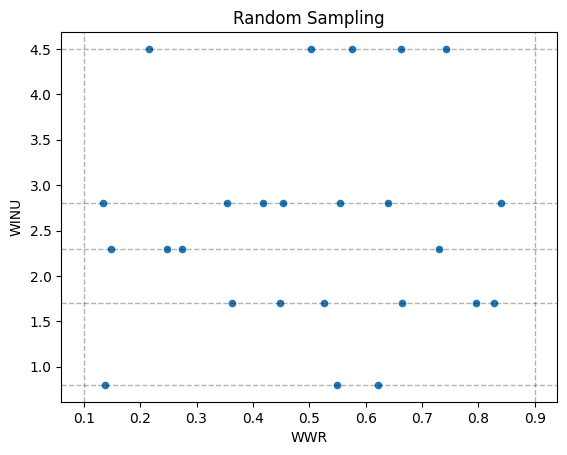

In [24]:
ax = X.to_df().plot.scatter(x="WWR", y="WINU", title="Random Sampling")
# Display a horizontal line for the discrete values of the Categorical space WINU
for h in space["WINU"].categories:
    ax.axhline(h, linestyle="--", linewidth=1, c="k", alpha=0.3)
for v in [space["WWR"].low, space["WWR"].high]:
    ax.axvline(v, linestyle="--", linewidth=1, c="k", alpha=0.3)

One of the caveats of random sampling is that it does not make sure that each dimension is sampled in its full range. Rerunning the cells above and replotting the sampled space can trigger other design options that could be more or less concentrated in some parts of the 4 corners of this simple 2D space.

Furthermore, we can illustrate this by looking at the frequency distribution of each dimension (using the pandas `hist()` method:

array([[<Axes: title={'center': 'WINU'}>,
        <Axes: title={'center': 'WWR'}>]], dtype=object)

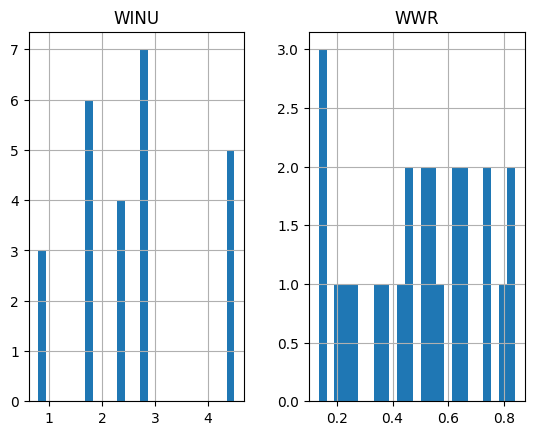

In [25]:
X.to_df().hist(bins=25)

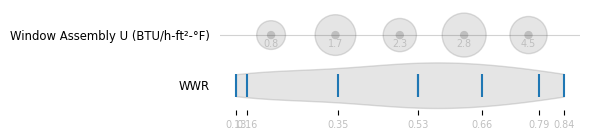

(<Figure size 600x150 with 2 Axes>, [<Axes: >, <Axes: >])

In [26]:
X.pretty_bubble_chart()

The output shows that some values are over-represented while others are less represented.

# Grid Sampling

Grid sampling, solves part of the issue of random sampling by making sure that samples are taken on a consistantly-spaced grid. This is especially relevant when dimensions are continuous (Real or Integer).

Grid sampling is specified using the "grid" keyword or by import the `Grid` sampling class which allows to specify parameters of the sampler:

In [27]:
from surrogate_schema.space.samplers import Grid

In [28]:
X = space.sample(25, Grid("include", use_full_layout=True, append_border="exclude"))

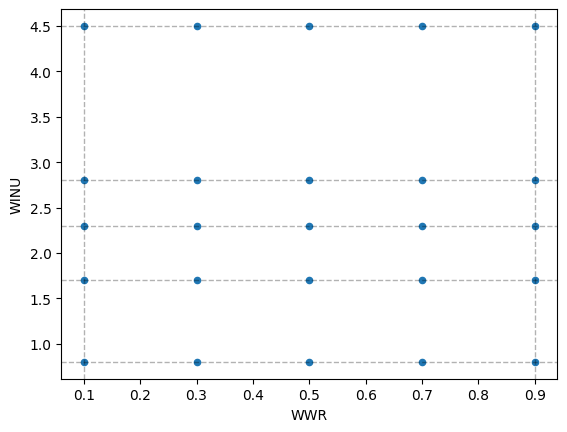

In [29]:
ax = X.to_df().plot.scatter(x="WWR", y="WINU")
# Display a horizontal line for the discrete values of the Categorical space WINU
for h in space["WINU"].categories:
    ax.axhline(h, linestyle="--", linewidth=1, c="k", alpha=0.3)
for v in [space["WWR"].low, space["WWR"].high]:
    ax.axvline(v, linestyle="--", linewidth=1, c="k", alpha=0.3)

The output shows that the grid is equally spaced. Remember that the `WWR` is a continuous dimension and that this sampling method automatically determined the spacing.

Next, we can confirm that we covered most of the design space by plotting the frequency distrivution of the sampled space:

array([[<Axes: title={'center': 'WINU'}>,
        <Axes: title={'center': 'WWR'}>]], dtype=object)

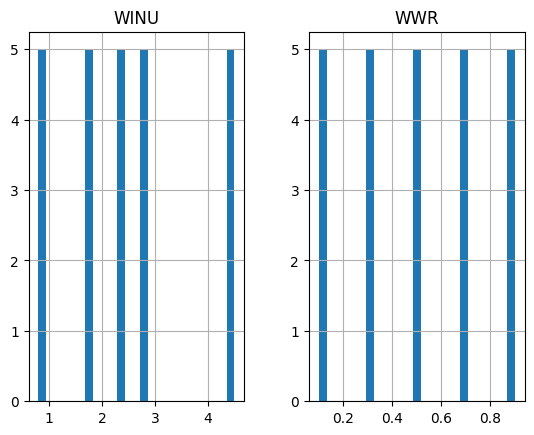

In [30]:
X.to_df().hist(bins=5 * 5)

## LHS Sampling

If we are interested in sampling more of the values that lie between the spacing created by the Grid sampling while still making sure that we are convering most of the available space, the Latin-Hypercube Sampling method is recommended. Latin-Hypercube sampling divides continuous spaces like the Grid method but samples the dimensions in a way that remembers which designs have already been drawn such that a dimension value is only drawn once.

We first import the Lhs class from the samplers module:

In [31]:
from surrogate_schema.space.samplers import Lhs

lhs_sampler = Lhs(lhs_type="centered", criterion="correlation")

Then, sample the design space:

In [32]:
X = space.sample(25, lhs_sampler)

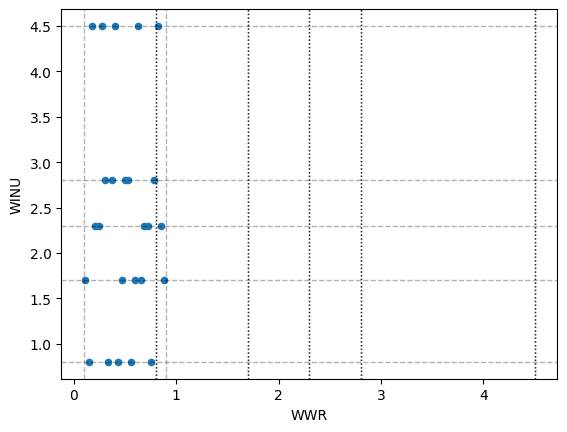

In [33]:
ax = X.to_df().plot.scatter(x="WWR", y="WINU")
# Display a horizontal line for the discrete values of the Categorical space WINU
for h in space["WINU"].categories:
    ax.axhline(h, linestyle="--", linewidth=1, c="k", alpha=0.3)
for v in [space["WWR"].low, space["WWR"].high]:
    ax.axvline(v, linestyle="--", linewidth=1, c="k", alpha=0.3)
for x, y in X.to_df().values:
    ax.axvline(x, linestyle=":", linewidth=1, c="k", alpha=0.3)

The frequency distribution bellow shows that a good range of WWRs and WINUs has been sampled

array([[<Axes: title={'center': 'WINU'}>,
        <Axes: title={'center': 'WWR'}>]], dtype=object)

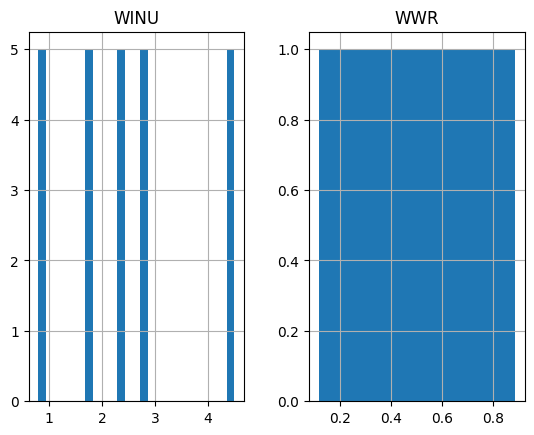

In [34]:
X.to_df().hist(bins=25)

## Other Sampling Methods

Two other methods have been developed to help us in our analyses: Sensitivity and Factorial design

The `Sensitivity` sampler will return the designs that are required to cover a sensitivity analysis: Different values of one dimension while all other dimensions are kept constant.

In [35]:
from surrogate_schema.space.samplers import Sensitivity, Factorial

In [36]:
X = space.sample(25, Sensitivity())

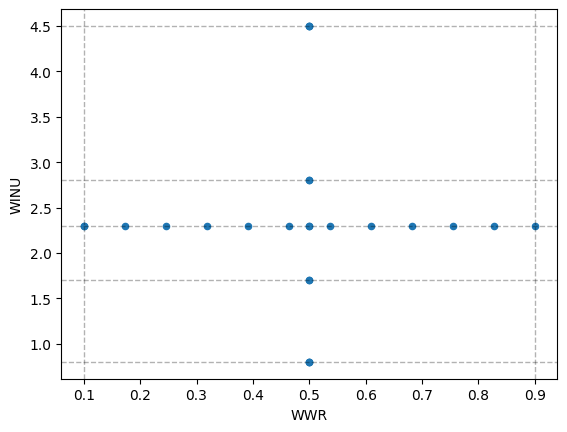

In [37]:
ax = X.to_df().plot.scatter(x="WWR", y="WINU")
# Display a horizontal line for the discrete values of the Categorical space WINU
for h in space["WINU"].categories:
    ax.axhline(h, linestyle="--", linewidth=1, c="k", alpha=0.3)
for v in [space["WWR"].low, space["WWR"].high]:
    ax.axvline(v, linestyle="--", linewidth=1, c="k", alpha=0.3)

## Factorial Design

Factorial designs render every possible permutations of a design space. For continuous dimensions, this would effectively produce an infinite number of designs. For this reason, the Factorial sampler only works with Categorical dimensions. Let's modify our space above and replace the WWR with a categorical one with the following values: 0.1, 0.3, 0.5, 0.7, 0.9.

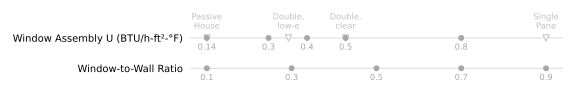

In [38]:
space = Space(
    dimensions=[
        Dimension(name="WINU", categories=[0.14, 0.3, 0.4, 0.5, 0.8]),
        Dimension(name="WWR", categories=[0.1, 0.3, 0.5, 0.7, 0.9]),
    ],
)
space

In [39]:
X = space.sample(None, Factorial())

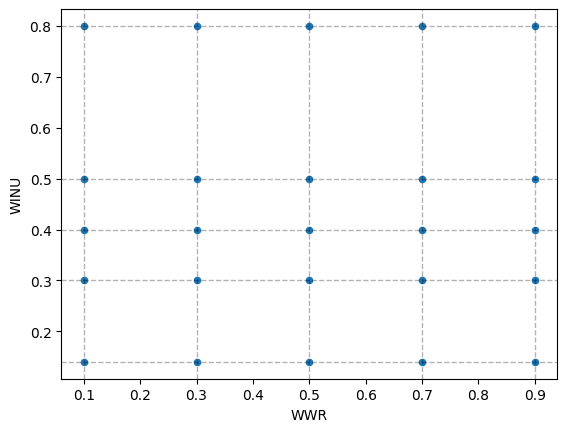

In [40]:
ax = X.to_df().plot.scatter(x="WWR", y="WINU")
# Display a horizontal line for the discrete values of the Categorical space WINU
for h in space["WINU"].categories:
    ax.axhline(h, linestyle="--", linewidth=1, c="k", alpha=0.3)
for v in space["WWR"].categories:
    ax.axvline(v, linestyle="--", linewidth=1, c="k", alpha=0.3)

The Factorial sampler looks a lot like the Grid sampler with the difference that the number of samples `n_samples` is not required in the `Space.sample` method; it will return the whole space.

<!--NAVIGATION-->
< [Introduction to Building Data Analytics](01.00-Introduction-to-Building-Data-Analytics.ipynb) | [Contents](Index.ipynb) | [Making a Sensitivity Analysis](01.02-Sensitivity-Analysis.ipynb) >